In [16]:
import numpy as np
import numpy.random as rd
import numpy.linalg
import pylab
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes="colorblind")
pylab.rcParams['figure.figsize'] = (30, 25)

rd.seed()

In [17]:
# DATA

Tau = np.array([[0, 3, 5, 7, 7],
      [2, 0, 2, 5, 5], 
      [4, 2, 0, 3, 3], 
      [8, 6, 4, 0, 2], 
      [7, 7, 5, 2, 0]]) *60

Lambda = np.array([2.8, 3.7, 5.5, 3.5, 4.6])/3600

P =   np.array([[0, 0.22, 0.32, 0.2, 0.26],
      [0.17, 0, 0.34, 0.21, 0.28], 
      [0.19, 0.26, 0, 0.24, 0.31], 
      [0.17, 0.22, 0.33, 0, 0.28], 
      [0.18, 0.24, 0.35, 0.23, 0]])

# CI

Nb_velos_ds_station_CI = np.array([20, 15, 17, 13, 18])

Nb_velos_par_trajet_CI = np.array([[0, 1, 0, 0, 0],
                          [1, 0, 1, 0, 0], 
                          [0, 1, 0, 1, 0], 
                          [0, 0, 1, 0, 1], 
                          [0, 0, 0, 1, 0]])

def lambda_itij(i, j):
    return Lambda[i] * P[i, j]
    
def lambda_tijj(i, j):
    if (i==j):
        return 0
    else :
        return 1 / Tau[i, j]

In [18]:
def pick_state(n, sum_lambda):
    tirage = rd.uniform()
    prog_lambda = 0
    for k in range(2):
        for j in range(5):
            for i in range(5):
                if i!=j :
                    prog_lambda += (lambda_itij(i, j) * (n[i, i] > 0)) if k == 0 else (lambda_tijj(i, j) * n[i, j])
                    if prog_lambda / sum_lambda > tirage:
                        return (i, i, i, j) if k == 0 else (i, j, j, j)
                    
def simul(t, do_the_plot = True, time_empty=False): #t est le temps en secondes
    etats = Nb_velos_par_trajet_CI + np.diag(Nb_velos_ds_station_CI)
    local = Nb_velos_ds_station_CI
    Pop1 = [local[0]]
    Pop2 = [local[1]]
    Pop3 = [local[2]]
    Pop4 = [local[3]]
    Pop5 = [local[4]]
    time = [0]
    # Par convention, on dit qu'un velo en station n est en trajet entre la station n et elle-même.
    sumtau = 0
    while sumtau <t :
        sum_lambda = 0
        for i in range (5):
            for j in range(5):
                if i!=j:
                    sum_lambda += lambda_itij(i, j) * (etats[i, i] > 0) + lambda_tijj(i, j) * etats[i, j]
        S = rd.exponential(1/sum_lambda)
        sumtau += S
        if sumtau > t : 
            break
        time += [time[-1] + S]
        (i_moins, j_moins, i_plus, j_plus) = pick_state(etats, sum_lambda)
        etats[i_moins][j_moins] -=1
        etats[i_plus][j_plus] +=1
        nouvel_etat = np.diag(etats)
        Pop1 += [nouvel_etat[0]]
        Pop2 += [nouvel_etat[1]]
        Pop3 += [nouvel_etat[2]]
        Pop4 += [nouvel_etat[3]]
        Pop5 += [nouvel_etat[4]]
    if do_the_plot:
        plt.figure()
        plt.clf()
        plt.plot(time, Pop1, label = "Population en station 1")
        plt.plot(time, Pop2, label = "Population en station 2")
        plt.plot(time, Pop3, label = "Population en station 3")
        plt.plot(time, Pop4, label = "Population en station 4")
        plt.plot(time, Pop5, label = "Population en station 5")
        plt.xlabel("Temps en seconde", fontsize=20)
        plt.ylabel("Population", fontsize=20)
        plt.title("Evolution des populations en fonction du temps", fontsize=20)
        plt.legend(fontsize=20)
    if time_empty :
        empty1, empty2, empty3, empty4, empty5 = 0, 0, 0, 0, 0
        for c in Pop1 :
            if c==0:
                empty1+=1
        for c in Pop2 :
            if c==0:
                empty2+=1
        for c in Pop3 :
            if c==0:
                empty3+=1
        for c in Pop4 :
            if c==0:
                empty4+=1
        for c in Pop5 :
            if c==0:
                empty5+=1
        emptiness_time = [100*empty1/t, 100*empty2/t, 100*empty3/t, 100*empty4/t, 100*empty5/t]
        return emptiness_time
    return etats

# 4)

On simule le processus de Markov ici sur 10 heures.

array([[36,  0,  0,  0,  0],
       [ 0, 29,  1,  0,  0],
       [ 0,  0, 17,  0,  2],
       [ 0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  2]])

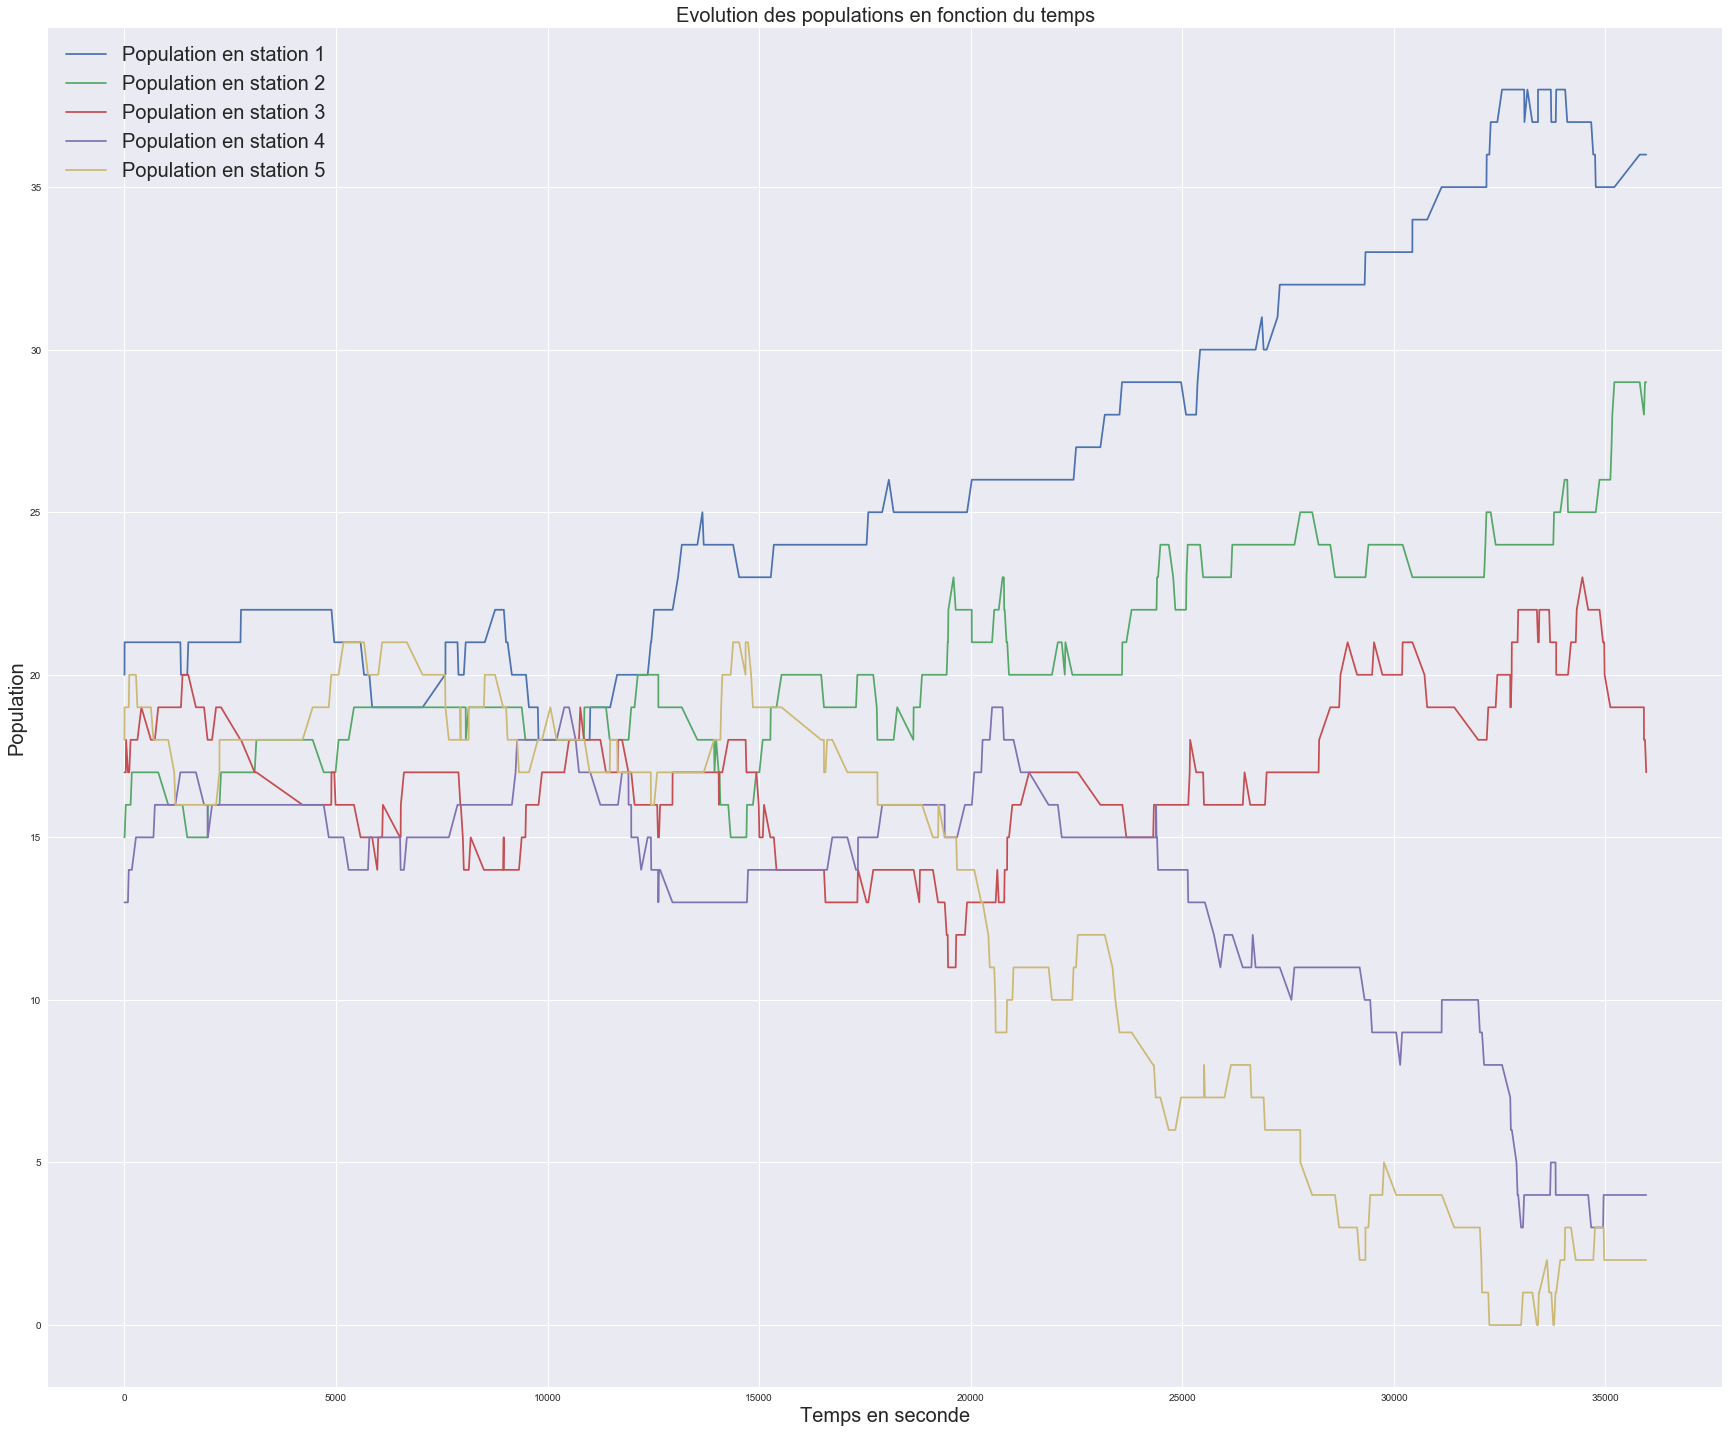

In [23]:
simul(36000)

# 5) 6)

On calcule les probabilités de chaque station d'être vide après 100 heures de simulation, ainsi que l'intervalle de confiance du résultat.

In [7]:
## proba d'être vide en pourcentage

N = 100
stations_vides = [0,0,0,0,0]
for i in range(N):
    etats = simul(360000, do_the_plot = False, time_empty=False)
    for k in range(5):
        if etats[k, k] == 0:
            stations_vides[k] += 1

for k in range (len(stations_vides)):
    stations_vides[k]/=N
print("Les probabilités empiriques que les stations soient vides après 100 heures sont :")
print(stations_vides)
    
ecart_type = [N/(N-1), N/(N-1), N/(N-1), N/(N-1), N/(N-1)]

for k in range(5):
    ecart_type[k]=np.sqrt(ecart_type[k]*(stations_vides[k]-stations_vides[k]**2))

epsilon = [1.96, 1.96, 1.96, 1.96, 1.96]
for i in range (len(epsilon)):
    epsilon[i] = epsilon[i]*ecart_type[i]/np.sqrt(N)

print("Les intervalles de confiance de ces résulats sont :")

intervals = [[stations_vides[0] - epsilon[0], stations_vides[0] + epsilon[0]],
             [stations_vides[1] - epsilon[1], stations_vides[1] + epsilon[1]],
             [stations_vides[2] - epsilon[2], stations_vides[2] + epsilon[2]],
             [stations_vides[3] - epsilon[3], stations_vides[3] + epsilon[3]],
             [stations_vides[4] - epsilon[4], stations_vides[4] + epsilon[4]]]

print(intervals)

Les probabilités empiriques que les stations soient vides après 100 heures sont :
[0.01, 0.01, 0.16, 0.02, 0.09]
Les intervalles de confiance de ces résulats sont :
[[-0.0096, 0.0296], [-0.0096, 0.0296], [0.08778322196121574, 0.23221677803878427], [-0.007578237650712777, 0.04757823765071278], [0.033625795712126365, 0.14637420428787362]]


# 7)

Changer les conditions initiales n'a que peu d'effets sur les probabilités, car le processus converge vers une distribution stationnaire indépendante des conditions initiales.

In [9]:
## Nouvelles CI 

Nb_velos_ds_station_CI = np.array([2, 29, 26, 11, 5])

Nb_velos_par_trajet_CI = np.array([[0, 0, 0, 1, 0],
                          [2, 0, 0, 0, 0], 
                          [0, 0, 0, 0, 2], 
                          [3, 0, 0, 0, 0], 
                          [1, 0, 0, 0, 0]])

N = 100
stations_vides = [0,0,0,0,0]
for i in range(N):
    etats = simul(360000, do_the_plot = False, time_empty=False)
    for k in range(5):
        if etats[k, k] == 0:
            stations_vides[k] += 1

for k in range (len(stations_vides)):
    stations_vides[k]/=N
print("Les probabilités empiriques que les stations soient vides après 100 heures sont :")
print(stations_vides)

Les probabilités empiriques que les stations soient vides après 100 heures sont :
[0.01, 0.03, 0.13, 0.04, 0.07]


# 8)

On calcule le pourcentage de temps pendant lequel chaque station est vide.

In [10]:
# Calcul du temps moyen sur N echantillons du pourcentage de temps où chaque station est vide

N = 1000
stations_vides = np.zeros(5)
mean_time_empty = [0, 0, 0, 0, 0]
for i in range(N):
        time_empty = simul(36000, False, True)
        for k in range(5):
            mean_time_empty[k] += time_empty[k]
for c in mean_time_empty :
    c = 100*c/N
print(mean_time_empty)

[23.186111111111106, 0.0, 3.430555555555553, 8.52777777777778, 69.60555555555564]


# 9) 

Selon nous, l'observation de la configuration finale est plus proche que le pourcentage d'être vide en temps car ce dernier va dépendre de ce qui a lieu avant la convergence vers la probabilité stationnaire - et rien ne nous donne la convergence uniforme vers celle-ci ! 

# 10) 

Il vaut mieux augmenter la durée de la simulation plutôt que le nombre de simulations pour améliorer la précision du résultat : le modèle sera plus avancé vers la probabilité stationnaire - à savoir sa limite. 

# 11)

On rappelle les équations du trafic :

$$\left \{ \begin{array}{l} \sum_{j = 1}^J \alpha_j = 1 \\
\forall j \leq J, \alpha_j \sum_{k = 1}^J \lambda_{jk} = \sum_{k = 1}^J \alpha_k \lambda_{kj} \end{array} \right .$$

Dans notre cas, seules sont possibles les transitions d'une station vers un trajet partant de cette station, et d'un trajet allant vers une station à cette même station. Ainsi, on peut réécrire les équations du trafic (on ne considère que 5 stations), avec la convention qu'un trajet d'une station vers elle-même représente la station en question (ie $\alpha_i \equiv \alpha_{t_{ii}}, \lambda_i \equiv \lambda_{t_{ii}}$) :

$$\left \{ \begin{array}{l} \sum _{i = 1}^5 \sum_{j = 1}^5 \alpha_{t_{ij}} = 1 \\
\forall i \leq 5, \left \{ \begin{array}{l} \alpha_i \sum_{j = 1, \neq i}^5 \lambda_{i, t_{ij}} = \sum_{j = 1, \neq i}^5 \alpha_{t_{ji}} \lambda_{t_{ji}, i} (1) \\
\forall j \neq i, \alpha_{t_{ij}} \lambda_{t_{ij}, j} = \alpha_i \lambda_{i, t_{ij}} (2) \end{array} \right. \end{array} \right .$$

On a ainsi : $(2) \Rightarrow \forall j \neq i, \alpha_{t_{ij}} = \alpha_i \frac{\lambda_{i, t_{ij}}}{\lambda_{t_{ij}, j}}$

On utilise cette relation sur le côté droit de l'équation dans $(1)$ (attention, i et j sont inversés) :

$$(1) \Rightarrow \forall i \leq 5, \alpha_i \sum_{j = 1, \neq i}^5 \lambda_{i, t_{ij}} = \sum_{j = 1, \neq i}^5 \alpha_j \lambda_{j, t_{ji}} \\
\Leftrightarrow \forall i \leq 5, \alpha_i \sum_{j = 1, \neq i}^5 \lambda_{i, t_{ij}} - \sum_{j = 1, \neq i}^5 \alpha_j \lambda_{j, t_{ji}} = 0 \\
\Leftrightarrow M\alpha = X$$

Avec : 
$$\alpha = \begin{pmatrix} \alpha_1 \\ ... \\ \alpha_5 \end{pmatrix} \\
M_{ij} = \left \{ \begin{array}{l} \sum_{k = 1, \neq i}^5 \lambda_{i, t_{ik}} \textrm{ si } i = j \\
 - \lambda_{j, t_{ji}} \textrm{ sinon } \end{array} \right .\\
X = 0$$

On remplace la dernière ligne de $M$ par une ligne de 1, et on remplace la dernière valeur de $X$ par un 1 pour être sûr de ne pas avoir une solution nulle. Cette équation permet ainsi d'obtenir les $\alpha_i$ comme solution de $\alpha = M^{-1}X$, et la relation $(2)$ permet de déduire les $\alpha_{t_{i, j}}$. On utilisera plus tard un facteur de normalisation pour respecter la condition de somme à 1 sur tous les $\alpha_i$ et $\alpha_{t_{ij}}$.

# 12)

On considère maintenant que le système contient un unique vélo. Cela signifie que l'espace des états se résume à un état par colonie, soit $S^2$ si $S$ est le nombre de stations. Pour nous, $S = 5$ donc on a $J = 25$ états.

# 13)

On utilise la définition ci-dessus des $\alpha_j$ pour exprimer la distribution d'équilibre du problème :

$$\pi(n) = G_N^{-1} \prod^J_{j=1} \frac{\alpha_j^{n_j}}{\prod^{n_j}_{r=1} \phi_j(r)}$$

Ici, comme nous ne considérons qu'un seul vélo, nos valeurs possibles de $n$ sont les $e_i$ les vecteurs de la base canonique de $\mathbb R^J$ avec $(e_i)_j  = \delta_{ij}$ avec $\delta$ le symbole de Kronecker. On a alors :

$$\mathbb P(n_k = 0) = 1 - \mathbb P(n_k = 1) = 1 - \pi(e_k) \\
= 1 - G_N^{-1} \prod^J_{j=1} \frac{\alpha_j^{\delta_{jk}}}{\prod^{\delta_{jk}}_{r=1} \phi_j(r)} \\
= 1 - G_N^{-1} \frac{\alpha_k}{\phi_k(1)} \\
= 1 - G_N^{-1} \alpha_k$$

On peut de plus calculer le terme de normalisation puisque notre unique vélo ne peut pas être dans deux colonies à la fois ni dans aucune :

$$\sum_{k = 1}^J \mathbb P(n_k = 1) = 1 \\
= \sum_{k = 1}^J G_N^{-1}  \alpha_k \\
\Leftrightarrow G_N = \sum_{k = 1}^J \alpha_k$$

In [11]:
X = np.zeros(5)
X[4] = 1

M = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        if i == j:
            M[i, j] = sum([ (lambda_itij(i, k) if i != k else 0) for k in range(5) ])
        else:
            M[i, j] = -lambda_itij(j, i)
M[4,:] = np.ones(5)
alpha = np.dot(np.linalg.inv(M), X)

all_alpha = [ [ alpha[i] if i == j else alpha[i] * lambda_itij(i, j) / lambda_tijj(i, j) for j in range(5) ] for i in range(5) ]

G_N = np.sum(all_alpha)

print("Probabilités théoriques que les stations soient vides :")
print([ 1 - all_alpha[i][i] / G_N for i in range(5) ])


Probabilités théoriques que les stations soient vides :
[0.8321704317214969, 0.8388546706096625, 0.8580139299585933, 0.8385161482338817, 0.8501158888898838]


# 14)

On obtient des valeurs empiriques pour ces probabilités de la même manière que l'on a pu le faire à la question 5, mais avec des conditions initiales telles qu'il n'y ait qu'un seul vélo en circulation. On remarque ainsi que les prédictions du modèle théorique sont toujours vérifiées avec moins de 3% d'erreur pour 1000 itérations.

In [12]:
## Nouvelles CI 

Nb_velos_ds_station_CI = np.array([0, 1, 0, 0, 0])

Nb_velos_par_trajet_CI = np.zeros((5, 5))


N = 1000
stations_vides = [0,0,0,0,0]
for i in range(N):
    etats = simul(360000, do_the_plot = False, time_empty=False)
    for k in range(5):
        if etats[k, k] == 0:
            stations_vides[k] += 1

for k in range (len(stations_vides)):
    stations_vides[k]/=N
print("Probabilités empiriques que les stations soient vides :")
print(stations_vides)

Probabilités empiriques que les stations soient vides :
[0.833, 0.809, 0.865, 0.845, 0.845]
